In [1]:
cd ..

/home/alberto/Work/course_interpretability_deep_learning


# Multi-omics stratification on PDAC patients

In [2]:
import os
import pandas as pd
import numpy as np
import optuna
import time
import dill
import shutil
from optuna.samplers import TPESampler

from src import settings
from explainability import FeatureImportance
from utils import transform_full_dataset

## Load dataset

In [3]:
methylation_data = pd.read_csv(settings.methylation_data_path, sep=";", index_col=0, decimal=",")
methylation_data.columns = methylation_data.columns.str.replace(".", "-")
methylation_data = methylation_data.T
methylation_data = methylation_data.astype(np.float32)
print("methylation_data.shape", methylation_data.shape)
methylation_data.head()

methylation_data.shape (153, 301195)


,cg00000029,cg00000236,cg00000289,cg00000292,cg00000321,cg00000622,cg00000658,cg00000714,cg00000721,cg00000734,...,ch.9.2262725R,ch.9.2285199R,ch.9.2298007R,ch.9.2473665R,ch.9.357218F,ch.9.377428R,ch.9.691424R,ch.9.837340R,ch.9.898515R,ch.9.991104F
TCGA-2J-AAB6,0.157951,0.836226,0.710511,0.560780,0.239194,0.016433,0.864604,0.087681,0.938775,0.061008,...,0.103136,0.053757,0.032478,NaN,0.064965,0.049776,0.115268,0.095954,0.084203,NaN
TCGA-2J-AAB8,0.300754,0.782242,0.574296,0.670286,0.424310,0.014747,0.885958,0.112524,0.930765,0.037198,...,0.028180,0.054483,0.022736,NaN,0.060835,0.036434,0.160082,0.059216,0.065342,0.166304
TCGA-2J-AAB9,0.257807,0.846522,0.534748,0.688073,0.295597,0.014649,0.895039,0.167297,0.940112,0.058407,...,0.059313,0.063187,0.032581,NaN,0.055342,0.069086,0.128546,0.120015,0.074940,NaN
TCGA-2J-AABA,0.239086,0.789457,0.474723,0.705372,0.530321,0.016919,0.884874,0.129581,0.910885,0.062167,...,0.122677,0.056068,0.023190,0.109351,0.056015,0.053238,0.082979,0.057172,0.045781,0.121676
TCGA-2J-AABE,0.168622,0.841684,0.591205,0.623799,0.322576,0.014408,0.898202,0.125415,0.941153,0.059365,...,0.046699,0.049177,0.032707,NaN,0.075854,0.062602,0.122072,0.082753,0.071240,NaN


In [4]:
rnaseq_data = pd.read_csv(settings.rnaseq_data_path, sep=";", index_col=0, decimal=",")
rnaseq_data = rnaseq_data.T
rnaseq_data = rnaseq_data.astype(np.float32)
print("rnaseq_data.shape", rnaseq_data.shape)
rnaseq_data.head()

rnaseq_data.shape (147, 20501)


,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
TCGA-2J-AAB6,82.549698,8.187100,0.0000,163.122803,1815.789551,8517.444336,1121.052612,1.169600,1.1696,834.502930,...,14.619900,269.005798,1053.216431,0.5848,683.625671,11696.491211,869.005798,601.754395,26.315800,0.0000
TCGA-2J-AAB8,56.930698,33.842499,0.0000,185.814301,16.921301,14413.913086,392.949493,9.400700,0.9401,801.880127,...,35.722698,356.286713,829.142212,3.7603,680.611023,5829.377441,828.202087,609.165710,85.546402,0.0000
TCGA-2J-AAB9,105.787804,21.436199,1.0718,166.709503,642.015015,24311.779297,1125.401855,50.375099,0.0000,862.808105,...,57.877800,381.564789,936.763123,1.0718,646.302307,8094.319336,1083.601318,573.419128,30.010700,0.0000
TCGA-2J-AABA,99.345497,18.788200,0.0000,99.276703,873.649597,10302.006836,633.161072,6.262700,18.7882,623.767029,...,52.606899,293.721588,1511.820923,1.2525,945.670898,4829.810547,1364.646851,793.486816,31.313601,0.6263
TCGA-2J-AABE,79.401901,3.083100,0.0000,134.564499,74.610802,11076.861328,710.343811,35.147202,0.0000,702.327698,...,56.728802,431.632507,1069.215454,0.6166,564.205322,7464.775879,832.434082,468.629608,48.096199,0.0000


In [5]:
samples = methylation_data.index.intersection(rnaseq_data.index)
methylation_data = methylation_data.loc[samples]
rnaseq_data = rnaseq_data.loc[samples]
assert methylation_data.index.equals(rnaseq_data.index)
Xs= [rnaseq_data, methylation_data]
print("common samples:", len(samples))

common samples: 147


In [6]:
date = "2023062618"
with open(os.path.join(settings.optimization_path, f'optimization_optuna_{date}.pkl'), 'rb') as file:
    optimization_study = dill.load(file)
optimization_results = pd.read_csv(os.path.join(settings.optimization_path, f"optimization_results_{date}.csv"))
best_trial = optimization_results.iloc[0]
print("optimization_results.shape", optimization_results.shape)
optimization_results.head()

optimization_results.shape (506, 56)


,number,value,datetime_start,datetime_complete,duration,params_divisor_units,params_features_per_component,params_lambda_coeff,params_n_clusters,params_n_epochs,...,user_attrs_val_dist_loss,user_attrs_val_dist_loss_list,user_attrs_val_loss,user_attrs_val_loss_list,user_attrs_val_loss_view_list,user_attrs_val_silhscore,user_attrs_val_silhscore_list,user_attrs_val_total_loss,user_attrs_val_total_loss_list,state
0,501,0.163591,2023-06-27 07:15:08.385178,2023-06-27 07:29:39.886878,0 days 00:14:31.501700,2,9,0.179886,2.0,80.0,...,22.959966,"[27.75557518005371, 78.60169982910156, 20.5489...",0.589241,"[0.5634028911590576, 0.634914755821228, 0.5719...","[0.5645923161506653, 0.6385385346412659]",0.163591,"[0.13774972, 0.12624748, 0.12726697, 0.1607680...",4.715641,"[5.552801609039307, 14.769259452819824, 4.2647...",COMPLETE
1,502,0.162827,2023-06-27 07:29:41.102885,2023-06-27 07:49:37.924477,0 days 00:19:56.821592,2,9,0.210878,2.0,80.0,...,22.437945,"[36.60449981689453, 25.86542510986328, 15.3619...",0.590230,"[0.5759981870651245, 0.6293062567710876, 0.573...","[0.5655155801773071, 0.6396599531173706]",0.162827,"[0.16576178, 0.16522004, 0.11999136, 0.0996076...",5.318566,"[8.296555519104004, 6.0792622566223145, 3.8077...",COMPLETE
2,505,0.153462,2023-06-27 08:51:00.586990,2023-06-27 09:10:28.564202,0 days 00:19:27.977212,2,9,0.201835,2.0,80.0,...,25.163505,"[20.011436462402344, 20.025657653808594, 13.80...",0.589781,"[0.5678296685218811, 0.6270660758018494, 0.592...","[0.5650894331932068, 0.6391655731201172]",0.153462,"[0.1372213, 0.10470337, 0.13370039, 0.1014813,...",5.665669,"[4.602327346801758, 4.664762020111084, 3.37358...",COMPLETE
3,20,0.149752,2023-06-26 21:42:18.864873,2023-06-26 21:43:55.222307,0 days 00:01:36.357434,2,5,0.081139,2.0,20.0,...,19.551882,"[14.899971008300781, 13.861332893371582, 14.68...",0.608227,"[0.6020955443382263, 0.643612802028656, 0.6064...","[0.5893636441230774, 0.6459534573554992]",0.149752,"[0.14876075, 0.12222156, 0.08077106, 0.1501677...",2.190145,"[1.800790786743164, 1.7654943466186523, 1.7936...",COMPLETE
4,503,0.144635,2023-06-27 07:49:39.139816,2023-06-27 08:09:35.080147,0 days 00:19:55.940331,2,9,0.197449,2.0,80.0,...,19.137837,"[9.212821960449219, 19.08188247680664, 18.7630...",0.589272,"[0.5646654367446899, 0.6228009462356567, 0.588...","[0.5639174604415893, 0.6399813556671142]",0.144635,"[0.1777916, 0.10118558, 0.13280979, 0.10733721...",4.363973,"[2.379190444946289, 4.389517784118652, 4.29368...",COMPLETE


In [7]:
transformed_Xs = transform_full_dataset(Xs=Xs, fit_pipelines = False, results_folder = settings.results_path)
transformed_X = pd.concat(transformed_Xs, axis = 1)
print("transformed_X.shape", transformed_X.shape)
transformed_X.head()

transformed_X.shape (147, 6912)


,A2ML1,A2M,A4GALT,AACS,AADAC,AAK1,AAMP,AATK,ABCA1,ABCA3,...,cg27518014,cg27541892,cg27546066,cg27576485,cg27578811,cg27594157,cg27604402,cg27610821,cg27618240,cg27645259
TCGA-2J-AAB6,1.838545,-1.000486,1.095929,-1.405823,-2.010877,0.094786,-1.083251,-0.538234,-0.429991,-1.131272,...,0.104428,1.295505,1.428531,-0.257988,0.883600,1.172822,0.723690,-0.823215,0.992312,2.282258
TCGA-2J-AAB8,-0.044025,-0.056539,-0.485821,-0.889678,0.457584,-1.121548,0.487510,0.251208,-0.645695,-1.232429,...,0.479146,-1.141428,-1.643287,-0.938267,0.189676,-0.775050,-0.363433,-0.760774,0.458498,-0.597939
TCGA-2J-AAB9,1.415203,0.881504,1.101775,-1.080933,0.098780,0.097744,-0.666669,0.423352,-0.909705,0.408378,...,0.305970,0.003199,-1.253669,-0.097550,-0.451130,-0.048385,0.143848,-0.866286,-0.383553,-0.342804
TCGA-2J-AABA,1.540599,-0.659173,0.233626,0.086201,-0.518542,-0.259241,0.307759,0.576417,0.354872,-1.008569,...,0.123747,-0.694590,0.567955,-0.300843,-1.632633,-0.836188,-0.376244,-1.017153,0.707431,-0.688826
TCGA-2J-AABE,0.542739,-0.529051,0.407191,1.104263,0.301339,-0.609332,0.820578,0.900868,-0.285007,-0.684110,...,0.534525,1.630993,1.171886,-1.097332,0.278700,-1.046977,0.008427,1.008485,0.473871,-0.628166


In [8]:
new_study = False
if new_study:
    date = time.strftime('%Y%m%d%H')
    feature_importance_study = optuna.create_study(direction="maximize")
    for file in os.listdir(settings.feature_importance_path):
        os.remove(os.path.join(settings.feature_importance_path, file))
    for view_idx, X in enumerate(transformed_Xs):
        features = X.columns.to_list()
        for feature_to_drop in features:
            feature_importance_study.enqueue_trial({"view_idx": view_idx, "feature_to_drop": feature_to_drop})
    print("Features tu explain:", len(feature_importance_study.trials))

else:
    date = "2023062710"
    with open(os.path.join(settings.feature_importance_path, f'feature_importance_results_{date}.pkl'), 'rb') as file:
        feature_importance_study = dill.load(file)

In [9]:
func_objective = lambda trial: FeatureImportance().objective(trial= trial, Xs= Xs, samples= samples, original_score = optimization_study.best_value,
                                                             features_per_component = optimization_study.best_params["features_per_component"],
                                                             in_channels_list = eval(best_trial["user_attrs_num_features"]),
                                                             hidden_channels_list = [view_hidden[1:] for view_hidden in eval(best_trial["user_attrs_num_units"])],
                                                             n_clusters = optimization_study.best_params["n_clusters"],
                                                             n_epochs = optimization_study.best_params["n_epochs"],
                                                             lambda_coeff = optimization_study.best_params["lambda_coeff"],
                                                             optimization_folder = settings.optimization_path,
                                                             random_state=settings.RANDOM_STATE, n_jobs= 4, folder= settings.feature_importance_path)

keep_trying = True
while keep_trying:
    try:
        feature_importance_study = FeatureImportance.optimize_optuna_and_save(study= feature_importance_study, n_trials = len(feature_importance_study.trials), date=date, 
                                                                              show_progress_bar= True, folder= settings.feature_importance_path, func= func_objective)
        if new_study:
            keep_trying = False
    except FileNotFoundError:
        pass
    except ValueError:
        pass

  0%|          | 0/6912 [00:00<?, ?it/s]

/home/alberto/Work/course_interpretability_deep_learning/src/explainability/feature_importance_analysis.py:35: FutureWarning: system_attrs has been deprecated in v3.1.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  view_idx = trial.system_attrs["fixed_params"]["view_idx"]
/home/alberto/Work/course_interpretability_deep_learning/src/explainability/feature_importance_analysis.py:36: FutureWarning: system_attrs has been deprecated in v3.1.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  feature_to_drop = trial.system_attrs["fixed_params"]["feature_to_drop"]
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU availa

<Axes: xlabel='RNA-seq'>

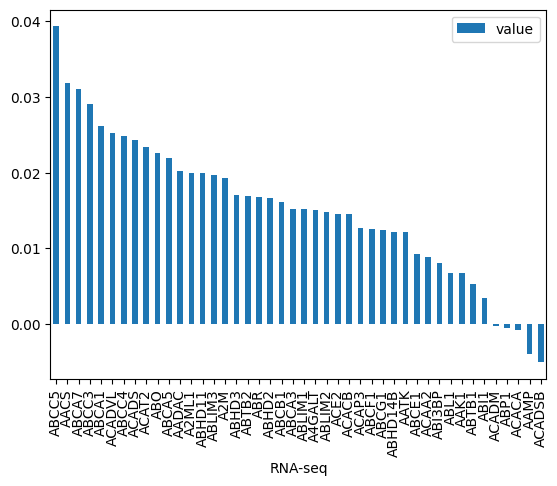

In [21]:
current_study = feature_importance_study.trials_dataframe()[["system_attrs_fixed_params", "value"]].dropna().sort_values("value", ascending = False)
current_study["system_attrs_fixed_params"] = current_study["system_attrs_fixed_params"].apply(lambda x: x["feature_to_drop"])
current_study.plot.bar(x='system_attrs_fixed_params', y='value', xlabel = "RNA-seq")